In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [9]:
import torch
import torch.nn as nn
from neuralop.models import FNO2d
from neuralop.data.datasets import DarcyDataset, NavierStokesDataset
from torch.utils.data import DataLoader
import numpy as np
import copy
from tqdm import tqdm

def get_dataset_loader(dataset_name, batch_size):
    if dataset_name == "DarcyFlow":
        dataset = DarcyDataset(
            root_dir='./data/darcy',
            n_train=1000, n_tests=[100],
            batch_size=batch_size, test_batch_sizes=[batch_size],
            train_resolution=64, test_resolutions=[64],
            download=True
        )
        train_loader = DataLoader(dataset.train_db, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset.test_dbs[64], batch_size=batch_size, shuffle=False)

    elif dataset_name == "NavierStokes":
        dataset = NavierStokesDataset(
            root_dir='./data/navier_stokes',
            n_train=1000, n_tests=[100],
            batch_size=batch_size, test_batch_sizes=[batch_size],
            train_resolution=128, test_resolutions=[128],
            download=True
        )
        train_loader = DataLoader(dataset.train_db, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset.test_dbs[128], batch_size=batch_size, shuffle=False)

    elif dataset_name == "CarCFD":
        dataset = CarCFDDataset(
            root_dir='./data/car_cfd/processed-car-pressure-data/',
            n_train=1000, n_test=200,
            query_res=[32, 32, 32],
            download=False
        )
        train_loader = dataset.train_loader
        test_loader = dataset.test_loader

    else:
        raise ValueError(f"Dataset {dataset_name} not supported yet.")

    sample_batch = next(iter(train_loader))
    in_channels = sample_batch["x"].shape[1]
    out_channels = sample_batch["y"].shape[1]

    return train_loader, test_loader, in_channels, out_channels
    
# 1. 모델 정의
#####################
# Model definitions
#####################

# FNO
class FNO(nn.Module):
    def __init__(self, n_modes_height=12, n_modes_width=12, hidden_channels=64, in_channels=1, out_channels=1, device="cuda"):
        super().__init__()
        self.fno = FNO2d(n_modes_height=n_modes_height,
        n_modes_width=n_modes_width,
        hidden_channels=hidden_channels,
        in_channels=in_channels,
        out_channels=out_channels,
        lifting_channels=hidden_channels).to(device)

    def forward(self, x):
        return self.fno(x)

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_channels=64, device="cuda"):
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, hidden_channels)
        self.enc2 = conv_block(hidden_channels, hidden_channels*2)
        self.enc3 = conv_block(hidden_channels*2, hidden_channels*4)
        
        # Middle
        self.middle = conv_block(hidden_channels*4, hidden_channels*8)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, 2, stride=2)
        self.dec3 = conv_block(hidden_channels*8, hidden_channels*4)
        self.upconv2 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, 2, stride=2)
        self.dec2 = conv_block(hidden_channels*4, hidden_channels*2)
        self.upconv1 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, 2, stride=2)
        self.dec1 = conv_block(hidden_channels*2, hidden_channels)
        
        # Final layer
        self.final = nn.Conv2d(hidden_channels, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
        
        self.to(device)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        
        # Middle
        m = self.middle(self.pool(e3))
        
        # Decoder
        d3 = self.upconv3(m)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final
        return self.final(d1)

# DeepONet
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        if len(layers) < 2:
            raise ValueError("At least two layers (input and output) are required.")
        self.model = nn.Sequential()
        for i in range(len(layers) - 2):
            self.model.add_module(f'fc{i}', nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f'act{i}', activation())
        self.model.add_module('fc_out', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.model(x)

class DeepONet(nn.Module):
    def __init__(self, input_dim=64*64, trunk_dim=2, latent_dim=100, H=64, W=64):
        super().__init__()
        self.H, self.W = H, W
        if input_dim != H * W:
            raise ValueError(f"input_dim ({input_dim}) must equal H*W ({H*W})")

        self.branch_net = MLP([input_dim, 200, 200, latent_dim])
        self.trunk_net = MLP([trunk_dim, 200, 200, latent_dim])

        # 좌표 그리드 생성 및 저장
        grid_x = torch.linspace(-1, 1, H)
        grid_y = torch.linspace(-1, 1, W)
        X, Y = torch.meshgrid(grid_x, grid_y, indexing='ij')  # [H, W]
        coords = torch.stack([X, Y], dim=-1).view(-1, 2)       # [H*W, 2]
        self.register_buffer("coords", coords)

    def forward(self, a_field):
        B, C, H, W = a_field.shape
        if C != 1:
            raise ValueError(f"Expected channel dimension to be 1, got {C}")
        if H != self.H or W != self.W:
            raise ValueError(f"Expected spatial dimensions ({self.H}, {self.W}), got ({H}, {W})")

        a_flat = a_field.view(B, -1)  # [B, H*W]
        branch_out = self.branch_net(a_flat)  # [B, latent_dim]

        coords = self.coords  # [H*W, 2]
        trunk_out = self.trunk_net(coords)  # [H*W, latent_dim]
        trunk_out = trunk_out.expand(B, -1, -1)  # [B, H*W, latent_dim]
        branch_out = branch_out.unsqueeze(1)  # [B, 1, latent_dim]

        out = torch.einsum('bmd,bnd->bn', branch_out, trunk_out)  # [B, H*W]
        return out.view(B, 1, H, W)
        
# 2. Fine-tuning 함수
def fine_tune(model, optimizer, criterion, train_loader, lr, device):
    model.train()
    # all_outputs = []
    # all_targets = []
    train_loss = 0.0
    

    for batch in train_loader:
        inputs, targets = batch["x"].to(device), batch["y"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # all_outputs.append(outputs.detach().cpu())
        # all_targets.append(targets.detach().cpu())
        train_loss += loss.item()

    # 전체 상대오차 계산
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)

    return model, copy.deepcopy(model.state_dict()), train_loss / len(train_loader)

def selfstudy(model1, optimizer1, criterion, train_loader, lr, device):
    model1.train()
    # all_outputs1 = []
    # all_targets1 = []
    train_loss1 = 0.0
    
    for batch in train_loader:
        inputs, targets = batch["x"].to(device), batch["y"].to(device)
        optimizer1.zero_grad()
        outputs1 = model1(inputs)
        loss1 = criterion(outputs1, targets)
        # total_loss1 += loss1.item()
        
        gap = torch.abs(outputs1 - targets) > loss1
        index1 = torch.where(gap)
        index2 = torch.where(~gap)
        
        if index1[0].numel() > 0:
            loss1 = 1.5*criterion(outputs1[index1[0], index1[1], index1[2], index1[3]], targets[index1[0], index1[1], index1[2], index1[3]])
        if index2[0].numel() > 0:
            loss2 = 0.5*criterion(outputs1[index2[0], index2[1], index2[2], index2[3]], targets[index2[0], index2[1], index2[2], index2[3]])
        loss = loss1 + loss2
        loss.backward()
        optimizer1.step()
        
        # all_outputs1.append(outputs1.detach().cpu())
        # all_targets1.append(targets.detach().cpu())
        train_loss1 += loss1.item()
        
    # outputs_all1 = torch.cat(all_outputs1, dim=0)
    # targets_all1 = torch.cat(all_targets1, dim=0)
    # rel_error1 = torch.norm(outputs_all1 - targets_all1) / torch.norm(targets_all1)
    # outputs_all2 = torch.cat(all_outputs2, dim=0)
    # targets_all2 = torch.cat(all_targets2, dim=0)
    # rel_error2 = torch.norm(outputs_all2 - targets_all2) / torch.norm(targets_all2)
    return model1, copy.deepcopy(model1.state_dict()), train_loss1 / len(train_loader)

# 7. 평가 함수
def evaluate(model, test_loader, device):
    criterion = nn.MSELoss()
    model.eval()
    # all_outputs = []
    # all_targets = []
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch["x"].to(device), batch["y"].to(device)
            outputs = model(inputs)
            # all_outputs.append(outputs.cpu())
            # all_targets.append(targets.cpu())
            test_loss += criterion(outputs, targets).item()
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)
    return test_loss / len(test_loader)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Darcy Flow 데이터셋 로드 및 입력 채널 확인
train_loader, test_loader, in_channels, out_channels = get_dataset_loader("DarcyFlow", batch_size=16)

# FNO 모델 초기화
pretrained_model1 = FNO(in_channels=in_channels, device=device)
pretrained_model2 = UNet(in_channels=in_channels, out_channels=out_channels, hidden_channels=64).to(device)
pretrained_model3 = DeepONet(input_dim=64*64, H=64, W=64).to(device)

epochs = 1000
seed=0
torch.cuda.empty_cache()
torch.manual_seed(seed)

model1 = copy.deepcopy(pretrained_model1).to(device)
model2 = copy.deepcopy(pretrained_model2).to(device)
model3 = copy.deepcopy(pretrained_model3).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
fine_tuned_models1 = []
train_loss_save1 = []
test_loss_save1 = []
for epoch in tqdm(range(epochs)):
    model1, weight1, loss1 = fine_tune(model1, optimizer1, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save1.append(loss1)
    # fine_tuned_models1.append(weight1)
    test_loss1 = evaluate(model1, test_loader, device)
    test_loss_save1.append(test_loss1)
    if epoch == 0:
        best_model1 = copy.deepcopy(model1)
        best_weight1 = copy.deepcopy(weight1)
    elif test_loss1 == min(test_loss_save1):
        best_model1 = copy.deepcopy(model1)
        best_weight1 = copy.deepcopy(weight1)

torch.cuda.empty_cache()
# fine_tuned_models2 = []
train_loss_save2 = []
test_loss_save2 = []
for epoch in tqdm(range(epochs)):
    model2, weight2, loss2 = fine_tune(model2, optimizer2, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save2.append(loss2)
    # fine_tuned_models2.append(weight2)
    test_loss2 = evaluate(model2, test_loader, device)
    test_loss_save2.append(test_loss2)
    if epoch == 0:
        best_model2 = copy.deepcopy(model2)
        best_weight2 = copy.deepcopy(weight2)
    elif test_loss2 == min(test_loss_save2):
        best_model2 = copy.deepcopy(model2)
        best_weight2 = copy.deepcopy(weight2)

torch.cuda.empty_cache()
# fine_tuned_models3 = []
train_loss_save3 = []
test_loss_save3 = []
for epoch in tqdm(range(epochs)):
    model3, weight3, loss3 = fine_tune(model3, optimizer3, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save3.append(loss3)
    # fine_tuned_models3.append(weight3)
    test_loss3 = evaluate(model3, test_loader, device)
    test_loss_save3.append(test_loss3)
    if epoch == 0:
        best_model3 = copy.deepcopy(model3)
        best_weight3 = copy.deepcopy(weight3)
    elif test_loss3 == min(test_loss_save3):
        best_model3 = copy.deepcopy(model3)
        best_weight3 = copy.deepcopy(weight3)

/home/geunseopark/anaconda3/envs/PGS_TORCH/lib/python3.12/site-packages/neuralop/data/datasets/pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.l

Loading test db for resolution 64 with 100 samples 


100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.47it/s]


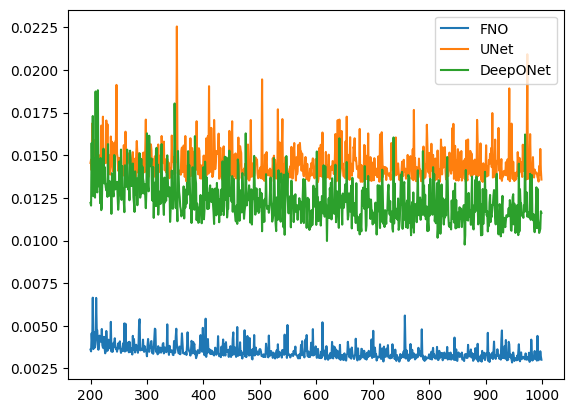

In [4]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO')
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet')
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet')
plt.legend()
plt.show()

In [10]:
torch.cuda.empty_cache()
# Self Study 학습
model12 = copy.deepcopy(pretrained_model1).to(device)
optimizer12 = torch.optim.Adam(model12.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11 = []
train_loss_save12 = []
test_loss_save12 = []
for epoch in tqdm(range(epochs)):
    model12, weight12, loss12 = selfstudy(model12, optimizer12, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save12.append(loss12)
    # fine_tuned_models12.append(weight12)
    test_loss12 = evaluate(model12, test_loader, device)
    test_loss_save12.append(test_loss12)
    if epoch == 0:
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
    elif test_loss12 == min(test_loss_save12):
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)


100%|███████████████████████████████████████| 1000/1000 [09:39<00:00,  1.73it/s]


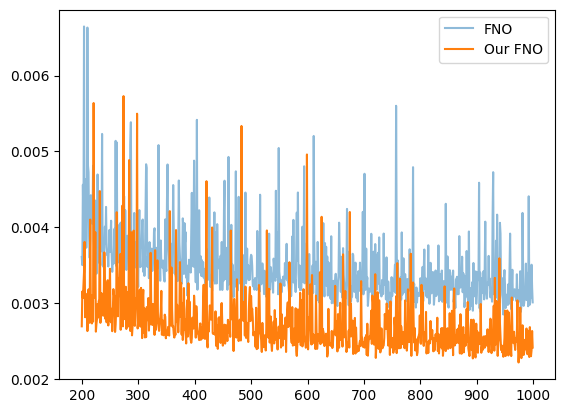

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save12[200:], label='Our FNO')
plt.legend()
plt.show()

In [12]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_study12 = evaluate(best_model12, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Study12 MSE: {mse_study12}")

Model Base1 MSE: 0.0028495904823232976
Model Study12 MSE: 0.0022169971406193717


In [13]:
torch.cuda.empty_cache()
# Study Group 학습
model21 = copy.deepcopy(pretrained_model2).to(device)
optimizer21 = torch.optim.Adam(model21.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save21 = []
test_loss_save21 = []
for epoch in tqdm(range(epochs)):
    model21, weight21, loss21 = selfstudy(model21, optimizer21, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save21.append(loss21)
    # fine_tuned_models23.append(weight23)
    test_loss21 = evaluate(model21, test_loader, device)
    test_loss_save21.append(test_loss21)
    if epoch == 0:
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)
    elif test_loss21 == min(test_loss_save21):
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)


100%|███████████████████████████████████████| 1000/1000 [08:48<00:00,  1.89it/s]


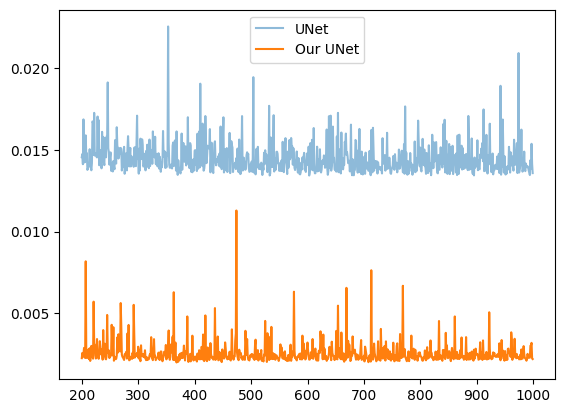

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save21[200:], label='Our UNet')
plt.legend()
plt.show()

In [15]:
# 평가
mse_base2 = evaluate(best_model2, test_loader, device)
mse_study21 = evaluate(best_model21, test_loader, device)

print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Study21 MSE: {mse_study21}")

Model Base2 MSE: 0.013426637010914939
Model Study21 MSE: 0.001985789110351886


In [22]:
torch.cuda.empty_cache()
# Study Group 학습
model31 = copy.deepcopy(pretrained_model3).to(device)
optimizer31 = torch.optim.Adam(model31.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save31 = []
test_loss_save31 = []
for epoch in tqdm(range(epochs)):
    model31, weight31, loss31 = selfstudy(model31, optimizer31, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save31.append(loss31)
    # fine_tuned_models23.append(weight23)
    test_loss31 = evaluate(model31, test_loader, device)
    test_loss_save31.append(test_loss31)
    if epoch == 0:
        best_model31 = copy.deepcopy(model31)
        best_weight31 = copy.deepcopy(weight31)
    elif test_loss31 == min(test_loss_save31):
        best_model31 = copy.deepcopy(model31)
        best_weight31 = copy.deepcopy(weight31)


100%|███████████████████████████████████████| 1000/1000 [02:17<00:00,  7.25it/s]


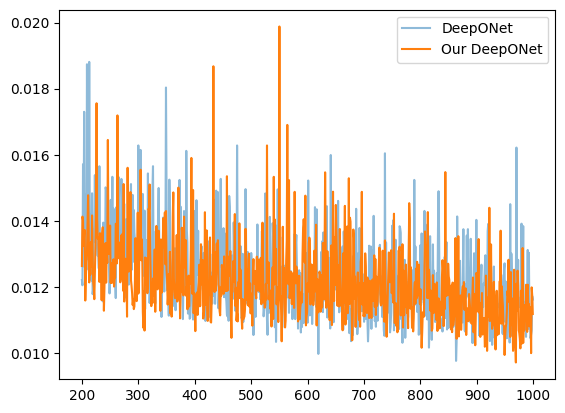

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save31[200:], label='Our DeepONet')
plt.legend()
plt.show()

In [24]:
# 평가
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study31 = evaluate(best_model31, test_loader, device)

print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study31 MSE: {mse_study31}")

Model Base3 MSE: 0.00976071400301797
Model Study31 MSE: 0.009711900260299444


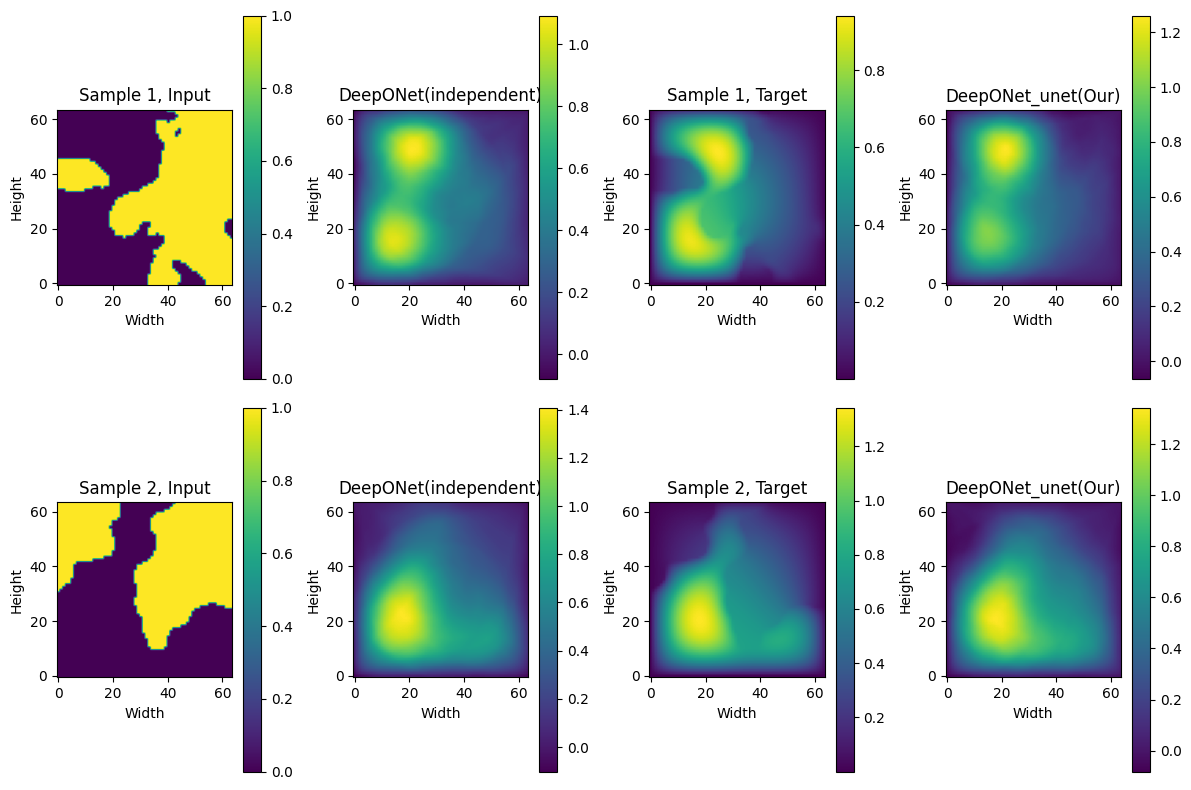

In [53]:
import matplotlib.pyplot as plt
# 첫 번째 배치 가져오기
batch = next(iter(test_loader))
inputs = batch['x']  # Shape: (16, 1, 128, 128)
targets = batch['y']  # Shape: (16, 1, 128, 128)

# 시각화를 위해 NumPy 배열로 변환
# inputs = inputs.cpu().numpy()  # (16, 1, 128, 128)
targets = targets.cpu().numpy()  # (16, 1, 128, 128)

num_samples = 2
fig, axes = plt.subplots(num_samples, 4, figsize=(12, 4 * num_samples))

best_model3.eval()
best_model32.eval()

for i in range(num_samples):
    # 입력 데이터
    ax = axes[i, 0]
    im = ax.imshow(inputs.cpu().numpy()[i, 0], cmap='viridis', origin='lower')
    ax.set_title(f'Sample {i+1}, Input')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # independent
    ax = axes[i, 1]
    im = ax.imshow(best_model3(inputs.to(device))[i, 0].detach().cpu().numpy(), cmap='viridis', origin='lower')
    ax.set_title(f'DeepONet(independent)')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # 타겟 데이터
    ax = axes[i, 2]
    im = ax.imshow(targets[i, 0], cmap='viridis', origin='lower')
    ax.set_title(f'Sample {i+1}, Target')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # ssmo
    ax = axes[i, 3]
    im = ax.imshow(best_model32(inputs.to(device))[i, 0].detach().cpu().numpy(), cmap='viridis', origin='lower')
    ax.set_title(f'DeepONet_unet(Our)')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()